This notebook was started July 30, 2019, at ICERM by Kaisa Taipale. I did some data processing in R first and saved the output as a CSV file. Here I start by reading in that csv file. I'm using Python 3.6 and scikit-learn 21.

The plan:
* do a train-test split on the data
* impute missing values for the training set
* do k-nearest neighbors, decision tree, and SVM just to see what kind of models they yield
* do mapper visualization of topology of questionnaire answers to see if there is a higher-dimensional structure that would bear more exploration.



In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import graphviz
from missingpy import MissForest
import sklearn

import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("numeric_sleep_questionnaire_data.csv")

In [3]:
df.head()

,Unnamed: 0,cshq_samebedtime,cshq_20mintosleep,cshq_asleepownbed,cshq_asleepotherbed,cshq_rocking,cshq_specialobject,cshq_parentsinroom,cshq_redyforbed,cshq_resistsgoingtobed,...,lower_face_height_score,lip_strain_score,palate_score,overjet_score,overjbite_score,posterior_bite_score,dental_tool_score,cshq_totalhrssleep,patient,record_id
0,1,1,1.0,1.0,1.0,1.0,3.0,1.0,1.0,2.0,...,0,0,0,0,0,0,0,14.0,CF,CF001
1,2,1,2.0,1.0,2.0,1.0,3.0,2.0,3.0,2.0,...,0,2,1,0,0,0,5,8.5,CF,CF004
2,3,1,1.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,...,1,1,0,0,0,0,2,10.0,CF,CF005
3,4,3,3.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,...,0,0,0,0,0,0,0,6.0,CF,CF006
4,5,1,2.0,1.0,1.0,2.0,3.0,3.0,2.0,3.0,...,0,0,0,0,0,0,2,10.0,CF,CF007


Let's split this into our features and labels.

Labels are from patient; we delete Unnamed 0, and we put the rest into features.

In [4]:
df.columns.values

array(['Unnamed: 0', 'cshq_samebedtime', 'cshq_20mintosleep',
       'cshq_asleepownbed', 'cshq_asleepotherbed', 'cshq_rocking',
       'cshq_specialobject', 'cshq_parentsinroom', 'cshq_redyforbed',
       'cshq_resistsgoingtobed', 'cshq_strugglesatbedtime',
       'cshq_afraiddark', 'cshq_afraidofsleepingalone',
       'cshq_sleepslittle', 'cshq_sleepsmuch', 'cshq_sleepsrightamt',
       'cshq_sleepsameeachday', 'cshq_wetsbed', 'cshq_talks',
       'cshq_restless', 'cshq_sleepwalk', 'cshq_movebed', 'cshq_pain',
       'cshq_grindteeth', 'cshq_snores', 'cshq_stopbreathing',
       'cshq_snortgasp', 'cshq_sleepawayhome', 'cshq_complainssleep',
       'cshq_screaming', 'cshq_nightmare', 'cshq_awakeonce',
       'cshq_awakemorethanonce', 'cshq_returntosleep', 'cshq_wakesself',
       'cshq_wakesalarm', 'cshq_wakesnegmood', 'cshq_someonewakes',
       'cshq_difficultyoutofbed', 'cshq_alertinam', 'cshq_wakesearly',
       'cshq_goodappetite', 'cshq_naps', 'cshq_suddensleep', 'cshq_tired',
 

In [5]:
X = df.drop(columns = ["patient", 'Unnamed: 0', 'record_id'])


In [6]:
y = df["patient"]
y_id = df['record_id']
y = pd.Series(np.where(y == 'CF', 1, 0))
## Change CF to 1 and Co (control) to 0

In [7]:
y_id_and_class = pd.concat([y, y_id], axis=1)
y_id_and_class = y_id_and_class.rename(columns={0: "patient"})
y_id_and_class

,patient,record_id
0,1,CF001
1,1,CF004
2,1,CF005
3,1,CF006
4,1,CF007
5,1,CF010
6,1,CF011
7,1,CF016
8,1,CF023
9,1,CF026


Time to do some machine learning!


## Train-test split

We could consider cross-validation, especially considering the small size of the dataset.


Do a simple train-test split, then do imputation of missing values.


In [8]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X, y_id_and_class, test_size=0.3, random_state=2387)
#y_train_id = y_train["record_id"]
#y_train = y_train["patient"]
#y_test_id = y_test["record_id"]
#y_test = y_test["patient"]

In [9]:
y_train = y_train.reset_index(drop=True)



Imputation of missing values: I'd like to use random forests to stay consistent with what Sunny has done in R. I'm going to use missingpy, a package that may not be supported by conda.........


I used pip install missingpy to install this.

In [10]:

imputer = MissForest()
X_imputed_train = imputer.fit_transform(X_train, y_train["patient"])

Iteration: 0
Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6


In [ ]:
X_imputed_test = imputer.fit_transform(X_test)

In [ ]:
X_imputed_train_df = pd.DataFrame(X_imputed_train, columns = X.columns.values)

In [ ]:
X_imputed_test_df = pd.DataFrame(X_imputed_test, columns = X.columns.values)
X_imputed_test.shape

In [ ]:
#X_imputed_train_df.to_csv("X_imputed_train_70percent.csv")
#y_train.to_csv("y_imputed_train_70percent.csv")

#X_imputed_test_df.to_csv("X_imputed_test_30percent.csv")
#y_test.to_csv("y_imputed_test_30percent.csv")

## Decision trees

Interpretability for the win!!!



In [99]:
from sklearn import tree

In [100]:
clf = tree.DecisionTreeClassifier(min_samples_leaf=4)
clf = clf.fit(X_imputed_train, y_train["patient"])

In [101]:
y_pred = clf.predict(X_imputed_test)

In [102]:
confusion_matrix(y_test["patient"], y_pred)

array([[14,  5],
       [ 4, 17]])

In [103]:
accuracy_score(y_pred, y_test["patient"])

0.775

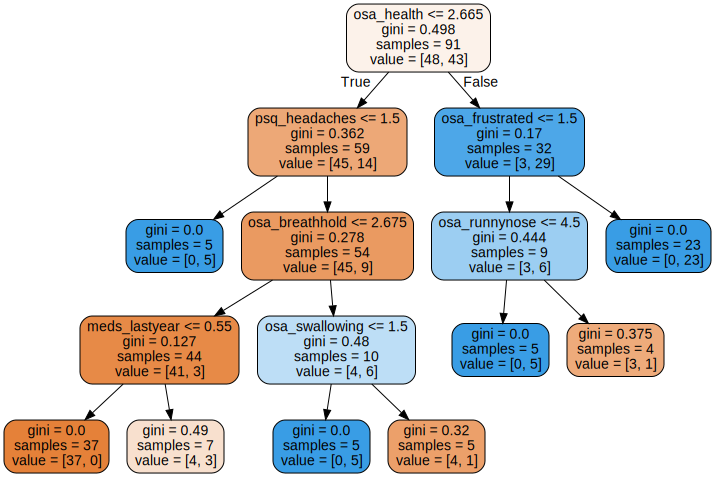

In [104]:
dot_data = tree.export_graphviz(clf, out_file=None, feature_names = X_train.columns.values, filled = True, rounded=True) 
graph = graphviz.Source(dot_data) 
graph

This is the most naive, fewest characters of typing decision tree possible. Note that changing the random state changes the decision tree a lot, so we really need to use Random Forests for feature selection here (as Sunny has done previously).

## Most naive k-nearest neighbors

In [105]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_score

In [106]:
classifier = KNeighborsClassifier(n_neighbors=3)
classifier.fit(X_imputed_train, y_train["patient"])
y_pred = classifier.predict(X_imputed_test)
cm = confusion_matrix(y_test["patient"], y_pred)
cm

array([[14,  5],
       [ 6, 15]])

In [107]:
accuracy_score(y_test["patient"], y_pred)

0.725

In [108]:
k_list = list(range(1,10,2))
cv_scores = []
for k in k_list:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_imputed_train, y_train["patient"], cv = 4, scoring = 'accuracy')
    cv_scores.append(scores.mean())

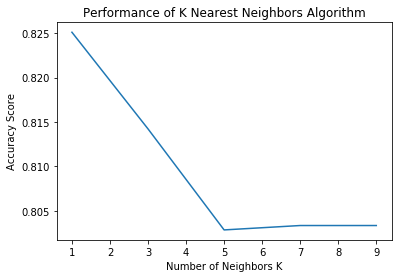

In [109]:
plt.figure()
plt.title('Performance of K Nearest Neighbors Algorithm')
plt.xlabel('Number of Neighbors K')
plt.ylabel('Accuracy Score')
plt.plot(k_list, cv_scores)

plt.show()

This graph above doesn't really match what I'm getting doing this by hand.... this is weird. I distrust something here.

In [110]:
cv_scores

[0.825098814229249,
 0.8142292490118577,
 0.8028656126482213,
 0.8033596837944664,
 0.8033596837944664]

## Support vector machines for classification

I'll start with linear support vector machines, using the SVC implementation in Python.

In [111]:
from sklearn import svm

In [112]:
svc = svm.SVC(kernel='linear')
svc = svc.fit(X_imputed_train, y_train["patient"])
y_pred = svc.predict(X_imputed_test)
accuracy_score(y_pred, y_test["patient"])

0.75

That looks better. Nice. Again, no parameter tuning yet at all!

For sure I think it's worth trying the RBF kernel in Python (Gaussian kernel) -- but one must tune gamma and C, and there are no guarantees it'll be good....

In [113]:
svc = svm.SVC(kernel='rbf')
svc = svc.fit(X_imputed_train, y_train["patient"])
y_pred = svc.predict(X_imputed_test)
accuracy_score(y_pred, y_test["patient"])

/Users/kaisa/anaconda/envs/py36/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning:

The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.



0.85

In [114]:
svc = svm.SVC(kernel='rbf', C=1.04, gamma=0.1)
svc = svc.fit(X_imputed_train, y_train["patient"])
y_pred = svc.predict(X_imputed_test)
accuracy_score(y_pred, y_test["patient"])

## really should use gridsearch to find good C, gamma.

0.75

To do: expand the machine learning classfications.

## Logistic regression



In [115]:
from sklearn.linear_model import LogisticRegression
clf = LogisticRegression(random_state=18, solver='newton-cg',multi_class='multinomial').fit(X_imputed_train, y_train["patient"])
# liblienar solver not allowed, sag and lbfgs don't converge

In [116]:
y_pred = clf.predict(X_imputed_test)
accuracy_score(y_pred, y_test["patient"])



0.775

## Unsupervised clustering: k-means with SVD for visualization




In [16]:
from sklearn.cluster import KMeans

In [17]:

model = KMeans(n_clusters=3)
model.fit(X_imputed_train)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [18]:
## Add SVD graphs

svd_train = np.linalg.svd(X_imputed_train)

In [19]:
svd_train[1]/sum(svd_train[1])

array([0.25499983, 0.05937273, 0.0372702 , 0.03114629, 0.02747995,
       0.02461631, 0.02408254, 0.02191202, 0.01874937, 0.01770089,
       0.01733012, 0.01534368, 0.01523579, 0.01469202, 0.01412859,
       0.01315021, 0.01264541, 0.01229623, 0.01195555, 0.011323  ,
       0.01130584, 0.01122221, 0.01087783, 0.01071599, 0.01026706,
       0.00971665, 0.00953121, 0.00930094, 0.00910423, 0.00899282,
       0.00883193, 0.00823257, 0.00805895, 0.00775752, 0.00774879,
       0.00768151, 0.00724855, 0.00706659, 0.00686472, 0.00682878,
       0.00680076, 0.00652383, 0.00650808, 0.00619027, 0.00596241,
       0.00580522, 0.00573769, 0.00543551, 0.005399  , 0.00532119,
       0.00512   , 0.00485271, 0.00478495, 0.004702  , 0.00452611,
       0.00447009, 0.0041747 , 0.004062  , 0.00388263, 0.0038609 ,
       0.00375139, 0.00367895, 0.00357514, 0.0034233 , 0.00330198,
       0.00316261, 0.0030326 , 0.00293271, 0.00285764, 0.00269061,
       0.00267542, 0.00250094, 0.00233397, 0.00215296, 0.00210

In [20]:
svd_train[2].shape ## this is question space

(103, 103)

### Insert little SVD visualization aside here



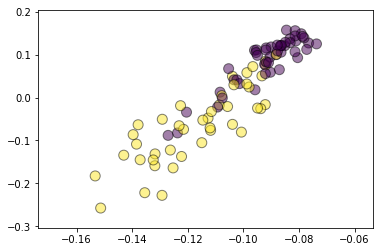

In [21]:
plt.scatter(svd_train[0][:,0], svd_train[0][:, 1], s = 100, alpha=0.5, edgecolor='k', c = y_train["patient"])

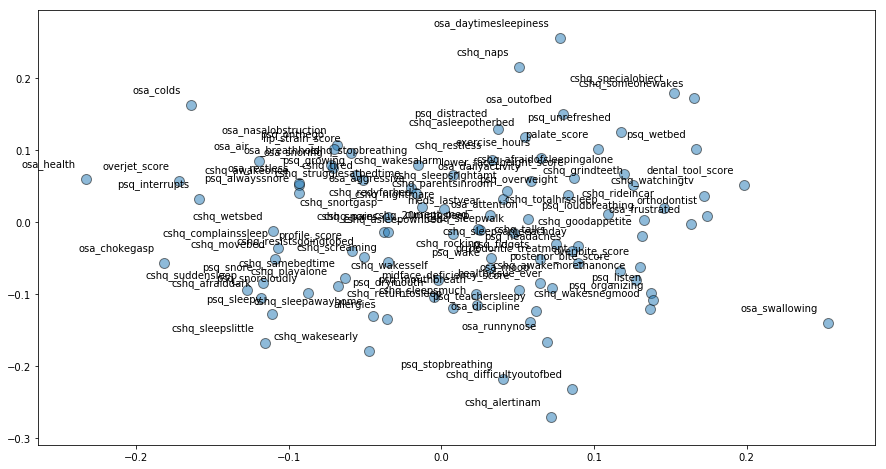

In [23]:
plt.scatter(svd_train[2][:,0], svd_train[2][:, 1], s = 100, alpha=0.5, edgecolor='k')


for label, x, y in zip(X.columns.values, svd_train[2][:,0], svd_train[2][:,1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        #bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
        #arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0')
    )
plt.rcParams["figure.figsize"] = (15,8)
plt.show()

In [24]:
labels=model.predict(X_imputed_train)
print(labels)

[1 2 2 2 2 2 1 2 1 2 0 2 2 1 2 1 1 0 2 2 1 2 0 2 0 1 0 0 2 1 1 0 2 2 1 0 1
 2 1 0 0 1 1 1 1 2 2 2 1 2 1 1 1 1 0 0 2 1 2 2 1 0 0 1 0 2 0 2 1 0 1 2 0 0
 2 2 2 2 2 0 0 2 1 2 2 2 2 0 0 0 2]


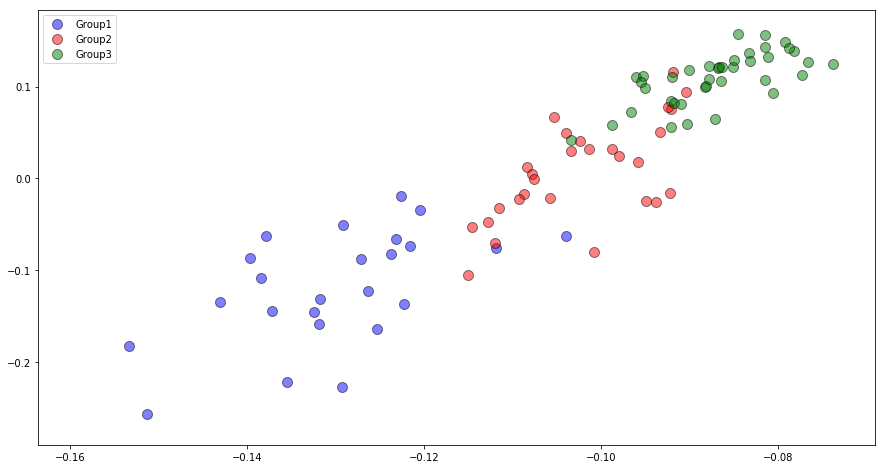

In [25]:

plt.scatter(svd_train[0][labels == 0, 0], svd_train[0][labels == 0, 1], s = 100, alpha=0.5, c = 'blue', edgecolor='k', label = 'Group1')
plt.scatter(svd_train[0][labels == 1, 0], svd_train[0][labels == 1, 1], s = 100, alpha=0.5, c = 'red', edgecolor='k', label = 'Group2')
plt.scatter(svd_train[0][labels == 2, 0], svd_train[0][labels == 2, 1], s = 100, alpha=0.5, c = 'green', edgecolor='k', label = 'Group3')
#plt.scatter(svd_train[0][labels == 3, 0], svd_train[0][labels == 3, 1], s = 100, alpha=0.5, c = 'yellow', edgecolor='k', label = 'Group3')

#plt.scatter(svd_train[0][labels == 4, 0], svd_train[0][labels == 4, 1], s = 100, alpha=0.5, c = 'purple', edgecolor='k', label = 'Group3')

#Centroids
#plt.scatter(svd_train[2][:,0], svd_train[2][:,1], c= labels)
#plt.scatter(model.cluster_centers_[:, 0], model.cluster_centers_[:,1], s = 150, marker='*', c = 'cyan', label = 'Centers')
#plt.ylim([1.5,5])
#plt.X_imputed_dflim([3.5,11])

plt.legend()
plt.show()

In [26]:
### Now need to look at each group and look at percentage of patients in each group with OSA
#y_train[]



In [127]:
pd.crosstab(labels,y_train['patient'])

patient,0,1
row_0,,
0,38,4
1,2,19
2,8,20


In [128]:

new_labels=model.predict(X_imputed_test)
pd.crosstab(new_labels,y_test['patient'])

patient,0,1
row_0,,
0,13,0
1,2,7
2,4,14


## Random forest for feature selection


In [129]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


In [130]:
# Create a random forest classifier
rfc = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the classifier
rfc.fit(X_imputed_train, y_train["patient"])


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1000,
                       n_jobs=-1, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [131]:
my_sorted_zip = sorted(zip(X.columns.values, rfc.feature_importances_), key=lambda x: x[1])
my_sorted_zip

[('overjbite_score', 0.0006966531714981808),
 ('orthodontic_treatment', 0.0008108068043105498),
 ('overjet_score', 0.0014468089807843213),
 ('cshq_suddensleep', 0.001558627267407557),
 ('psq_onthego', 0.0015605212637664458),
 ('cshq_asleepownbed', 0.001933600062399999),
 ('allergies', 0.0019558408116690726),
 ('cshq_wakesalarm', 0.001959720947371868),
 ('cshq_sleepawayhome', 0.0019950021519354925),
 ('posterior_bite_score', 0.002020132158612508),
 ('cshq_difficultyoutofbed', 0.0020677668457147877),
 ('cshq_strugglesatbedtime', 0.002258878026246616),
 ('cshq_sleepsmuch', 0.0023071276060209218),
 ('cshq_samebedtime', 0.002354623682254294),
 ('cshq_nightmare', 0.00237024769890683),
 ('profile_score', 0.0024237798609211604),
 ('cshq_screaming', 0.002438913434960037),
 ('cshq_rocking', 0.002454464683994857),
 ('lip_strain_score', 0.0025371637616650442),
 ('cshq_afraidofsleepingalone', 0.00259275183152243),
 ('cshq_20mintosleep', 0.0026142710593491554),
 ('psq_alwayssnore', 0.002674133042486

Top ten factors according to this:
('psq_mouthbreath', 0.027886480067040646),
 ('osa_daytimesleepiness', 0.02971198426703846),
 ('osa_health', 0.03274312204999525),
 ('osa_nasalobstruction', 0.035306371720622495),
 ('osa_snoring', 0.036481759821034396),
 ('osa_air', 0.03707664073956683),
 ('cshq_tired', 0.03742462338628731),
 ('osa_chokegasp', 0.039078145817610474),
 ('osa_breathhold', 0.05434061329146373),
 ('psq_loudbreathing', 0.05818188911185783)]

## Topological modeling

Let's use kepler-mapper to do some visualization and see if there is a higher-dimensional sort-of-continuous structure.

In [27]:
import kmapper as km
from sklearn import ensemble
from sklearn import preprocessing
from kmapper.plotlyviz import *
import warnings
import plotly.graph_objs as go
import plotly.io as pio
from ipywidgets import (HBox, VBox)

In [28]:
## Set colors here 
# Green to red
pl_brewer = [[0.0, '#006837'],
             [0.1, '#1a9850'],
             [0.2, '#66bd63'],
             [0.3, '#a6d96a'],
             [0.4, '#d9ef8b'],
             [0.5, '#ffffbf'],
             [0.6, '#fee08b'],
             [0.7, '#fdae61'],
             [0.8, '#f46d43'],
             [0.9, '#d73027'],
             [1.0, '#a50026']]

bgcolor = 'rgba(255,255,255, 0.9)' #white background for publication
#y_gridcolor = 'rgb(150,150,150)'# on a black background the gridlines are set on  grey
y_gridcolor = 'rgb(10,10,10,0.9)' #
my_colorscale = pl_brewer

In [29]:
# Need to redo missing value imputation for whole data set
# Or should we be doing mapper only on subset of data and then testing our hypotheses? Yes, probably....
#imputer = MissForest()
#X_imputed = imputer.fit_transform(X, y)


In [30]:
X_scale_train = sklearn.preprocessing.scale(X_imputed_train)
X_scale_train_df = pd.DataFrame(X_scale_train, columns = X.columns.values)

In [31]:
## Initial run of mapper algorithm. This sets the complex and everything after will be based on this.

mapper = km.KeplerMapper(verbose=0)
lens_euc = mapper.fit_transform(X_scale_train, distance_matrix = 'Euclidean', projection='sum')
# Define the simplicial complex
scomplex = mapper.map(lens_euc,
                      X_scale_train,
                      nr_cubes=6,
                      overlap_perc=0.6,
                      clusterer=sklearn.cluster.KMeans(n_clusters=4,
                                                       random_state=24))

color_function = np.array(y_train["patient"])

kmgraph,  mapper_summary, colorf_distribution = get_mapper_graph(scomplex, 
                                                                 color_function,  
                                                                 color_function_name='percent osa', 
                                                                 colorscale=my_colorscale)

# assign to node['custom_tooltips'] the id number of the person
for node in kmgraph['nodes']:
    node['custom_tooltips'] = y_train["record_id"][scomplex['nodes'][node['name']]]

In [32]:
plotly_graph_data = plotly_graph(kmgraph, graph_layout='fr', colorscale=my_colorscale, 
                                 factor_size=6, edge_linewidth=2)
layout = plot_layout(title="People clustered by questionnaire data,<br> colored by proportion with OSA",  
                     width=620, height=570,
                     annotation_text=get_kmgraph_meta(mapper_summary),  
                     bgcolor=bgcolor)

fw_graph = go.FigureWidget(data=plotly_graph_data, layout=layout)
fw_hist = node_hist_fig(colorf_distribution, bgcolor=bgcolor,
                        y_gridcolor=y_gridcolor)
fw_summary = summary_fig(mapper_summary, height=300)
dashboard = hovering_widgets(kmgraph, 
                             fw_graph, 
                             ctooltips=True, # ctooltips = True, because we assigned a label to each 
                                             #cluster member
                             bgcolor=bgcolor,
                             y_gridcolor=y_gridcolor)

#Update the fw_graph colorbar, setting its title:
    
fw_graph.data[1].marker.colorbar.title = 'OSA'

In [33]:
VBox([fw_graph, HBox([fw_summary, fw_hist])])

    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

TO DO: add participant ids again (back in R code?), add tooltips above, look at variables by cluster


In [34]:
dashboard

    'data': [{'hoverinfo': 'none',
              'line': {'color'…

In [143]:
# Use this to look into the data structure of the graph

kmgraph['nodes']


[{'id': 0,
  'name': 'cube0_cluster1',
  'member_ids': [1,
   2,
   4,
   5,
   7,
   9,
   11,
   12,
   15,
   18,
   19,
   20,
   21,
   33,
   37,
   47,
   49,
   59,
   60,
   65,
   67,
   71,
   75,
   76,
   77,
   78,
   81,
   84,
   85,
   86,
   90],
  'color': 0.06451612903225806,
  'size': 4,
  'cluster': {'above': [], 'below': [], 'size': 31},
  'distribution': [{'height': 100.0,
    'perc': 93.5,
    'color': 'rgb(13, 128, 67)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(64, 170, 89)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(134, 203, 102)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(191, 228, 122)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(236, 247, 164)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(254, 239, 164)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(253, 198, 117)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(248, 141, 81)'},
   {'height': 0.0, 'perc': 0.0, 'color': 'rgb(229, 78, 52)'},
   {'height': 7.0, 'perc': 6.5, 'color': 

In [43]:
## Let's try to write a function to color according to a desired variable. 
## This function is going to color by percent in top quartile -- I'm doing this because 
## with random forest imputation, we're going to have a whole range of imputed values
## I'll make a bottom percent function too I think....

def color_graph_by_top_quartile_variable(currentvariable):

    # Set the variable you want to use
    y_current = np.array(X_scale_train_df[currentvariable])

    ## Extract the top quartile from the training set
    ser, bins = pd.qcut(X_scale_train_df[currentvariable],[0,.75, 1.],labels = ["bottom","top quartile"], retbins=True)
    ## To apply it to another data set use this:
    #pd.cut((another dataset), bins=bins, include_lowest=True)

    tooltips = list(fw_graph.data[1].text) # maintain tooltips as record number


    current_color = []
    for j, node in enumerate(kmgraph['nodes']):
        member_label_ids = y_current[scomplex['nodes'][node['name']]]
        member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom","top quartile"],include_lowest=True)
        label_type, label_counts = np.unique(member_labels, return_counts=True) 
        print(label_type, label_counts)
    
        n_members = label_counts.sum()
        # if only one type of member, assign proportion all or none
        if label_type.shape[0] == 1:
            if label_type[0] == "top quartile":
                current_color.append(1)
            else:
                current_color.append(0)
        else:        
            # label with proportion of satisfied, which comes second in our list label_counts
            current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
        for m in range(len(label_counts)):
            tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
        tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

    fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
    with fw1_sg.batch_update():
        fw1_sg.data[1].text = tooltips # add the new tooltips
        fw1_sg.data[1].marker.color = current_color # update node colors
        fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
        fw1_sg.data[1].marker.showscale = True # remove the colorbar
        fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>quartile'
    
        fw1_sg.layout.title = "Colored by proportion in top quartile of population " + currentvariable
    
    return HBox([fw1_sg])

In [44]:
color_graph_by_top_quartile_variable('osa_breathhold')

['bottom' 'top quartile'] [30  1]
['bottom'] [3]
['bottom' 'top quartile'] [3 1]
['bottom'] [1]
['bottom'] [16]
['bottom' 'top quartile'] [6 3]
['bottom'] [7]
['bottom' 'top quartile'] [7 1]
['bottom' 'top quartile'] [6 2]
['bottom' 'top quartile'] [3 5]
['bottom' 'top quartile'] [8 2]
['bottom'] [3]
['bottom'] [3]
['bottom' 'top quartile'] [1 3]
['bottom' 'top quartile'] [1 1]
['top quartile'] [6]
['bottom' 'top quartile'] [1 2]
['bottom'] [2]
['top quartile'] [1]
['top quartile'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

['bottom half' 'top half'] [29  2]
['bottom half'] [3]
['top half'] [4]
['top half'] [1]
['bottom half' 'top half'] [12  4]
['bottom half' 'top half'] [1 8]
['bottom half' 'top half'] [5 2]
['bottom half' 'top half'] [6 2]
['bottom half' 'top half'] [4 5]
['top half'] [9]
['bottom half' 'top half'] [1 3]
['bottom half' 'top half'] [2 5]
['bottom half' 'top half'] [1 3]
['top half'] [6]
['top half'] [1]
['top half'] [3]
['bottom half' 'top half'] [1 2]
['top half'] [2]
['top half'] [1]
['top half'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [146]:


y_current = np.array(X_scale_train_df['cshq_someonewakes'])

######## add the bins here somehow

## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['cshq_someonewakes'],[0,.5, 1.],labels = ["bottom half","top half"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom half","top half"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top half":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>half'
    
    fw1_sg.layout.title = "Colored by proportion in top half,<br> cshq_someonewakes"
    
HBox([fw1_sg])

['bottom half' 'top half'] [19 12]
['top half'] [3]
['bottom half' 'top half'] [2 2]
['top half'] [1]
['bottom half' 'top half'] [ 6 10]
['bottom half' 'top half'] [6 3]
['bottom half' 'top half'] [2 5]
['bottom half'] [8]
['bottom half' 'top half'] [4 5]
['bottom half' 'top half'] [5 4]
['bottom half'] [4]
['bottom half' 'top half'] [3 4]
['bottom half' 'top half'] [2 2]
['bottom half' 'top half'] [2 4]
['bottom half'] [1]
['bottom half' 'top half'] [2 1]
['bottom half'] [3]
['bottom half'] [2]
['bottom half'] [1]
['bottom half'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [147]:

y_current = np.array(X_scale_train_df['osa_daytimesleepiness'])

######## add the bins here somehow

## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['osa_daytimesleepiness'],[0,.5, 1.],labels = ["bottom half","top half"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom half","top half"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top half":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>half'
    
    fw1_sg.layout.title = "Colored by proportion in top half,<br> osa_daytimesleepiness"
    
HBox([fw1_sg])

['bottom half' 'top half'] [29  2]
['bottom half'] [3]
['bottom half' 'top half'] [1 3]
['bottom half'] [1]
['bottom half' 'top half'] [11  5]
['bottom half' 'top half'] [2 7]
['bottom half' 'top half'] [5 2]
['bottom half' 'top half'] [7 1]
['bottom half' 'top half'] [4 5]
['top half'] [9]
['bottom half' 'top half'] [2 2]
['bottom half' 'top half'] [3 4]
['top half'] [4]
['top half'] [6]
['top half'] [1]
['top half'] [3]
['top half'] [3]
['bottom half' 'top half'] [1 1]
['top half'] [1]
['bottom half'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [148]:


y_current = np.array(X_scale_train_df['cshq_difficultyoutofbed'])

######## add the bins here somehow

## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['cshq_difficultyoutofbed'],[0,.5, 1.],labels = ["bottom half","top half"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom half","top half"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top half":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>half'
    
    fw1_sg.layout.title = "Colored by proportion in top half,<br> cshq_difficultyoutofbed"
    
HBox([fw1_sg])

['bottom half' 'top half'] [29  2]
['top half'] [3]
['bottom half'] [4]
['bottom half'] [1]
['bottom half' 'top half'] [10  6]
['bottom half'] [9]
['bottom half' 'top half'] [3 4]
['bottom half'] [8]
['bottom half' 'top half'] [5 4]
['bottom half' 'top half'] [6 3]
['bottom half'] [4]
['bottom half' 'top half'] [3 4]
['bottom half'] [4]
['bottom half' 'top half'] [3 3]
['bottom half'] [1]
['bottom half' 'top half'] [1 2]
['bottom half' 'top half'] [2 1]
['bottom half'] [2]
['bottom half'] [1]
['bottom half'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [149]:

y_current = np.array(X_scale_train_df['osa_chokegasp'])


## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['osa_chokegasp'],[0,.75, 1.],labels = ["bottom 3/4","top"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom 3/4","top"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>quartile'
    
    fw1_sg.layout.title = "Colored by proportion in top quartile,<br> choking and gasping symptoms"
    
HBox([fw1_sg])

['bottom 3/4'] [31]
['bottom 3/4'] [3]
['bottom 3/4' 'top'] [3 1]
['bottom 3/4'] [1]
['bottom 3/4'] [16]
['bottom 3/4' 'top'] [7 2]
['bottom 3/4'] [7]
['bottom 3/4'] [8]
['bottom 3/4' 'top'] [8 1]
['bottom 3/4' 'top'] [3 6]
['bottom 3/4'] [4]
['bottom 3/4'] [7]
['bottom 3/4'] [4]
['top'] [6]
['bottom 3/4'] [1]
['bottom 3/4' 'top'] [1 2]
['bottom 3/4' 'top'] [1 2]
['top'] [2]
['top'] [1]
['top'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [150]:

y_current = np.array(X_scale_train_df['osa_outofbed'])


## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['osa_outofbed'],[0,.75, 1.],labels = ["bottom 3/4","top"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom 3/4","top"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>half'
    
    fw1_sg.layout.title = "Colored by proportion in top quartile"
    
HBox([fw1_sg])

['bottom 3/4'] [31]
['bottom 3/4' 'top'] [2 1]
['bottom 3/4'] [4]
['bottom 3/4'] [1]
['bottom 3/4' 'top'] [13  3]
['bottom 3/4' 'top'] [8 1]
['bottom 3/4' 'top'] [5 2]
['bottom 3/4'] [8]
['bottom 3/4' 'top'] [3 6]
['bottom 3/4' 'top'] [7 2]
['bottom 3/4'] [4]
['bottom 3/4' 'top'] [4 3]
['bottom 3/4' 'top'] [3 1]
['bottom 3/4' 'top'] [2 4]
['top'] [1]
['bottom 3/4' 'top'] [1 2]
['bottom 3/4' 'top'] [1 2]
['bottom 3/4'] [2]
['bottom 3/4'] [1]
['bottom 3/4'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [151]:

y_current = np.array(X_scale_train_df['osa_mood'])


## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['osa_mood'],[0,.5, 1.],labels = ["bottom half","top"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom half","top"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>half'
    
    fw1_sg.layout.title = "Colored by proportion in top half, <br> negative mood on waking"
    
HBox([fw1_sg])

['bottom half' 'top'] [25  6]
['bottom half' 'top'] [2 1]
['bottom half' 'top'] [3 1]
['bottom half'] [1]
['bottom half' 'top'] [12  4]
['bottom half' 'top'] [6 3]
['bottom half' 'top'] [3 4]
['bottom half' 'top'] [5 3]
['bottom half' 'top'] [5 4]
['top'] [9]
['bottom half' 'top'] [2 2]
['bottom half' 'top'] [3 4]
['top'] [4]
['top'] [6]
['top'] [1]
['top'] [3]
['top'] [3]
['top'] [2]
['top'] [1]
['top'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

In [152]:

y_current = np.array(X_scale_train_df['osa_runnynose'])


## This extracts the top half and bottom half from the training set
ser, bins = pd.qcut(X_scale_train_df['osa_runnynose'],[0,.5, 1.],labels = ["bottom half","top"], retbins=True)
## To apply it to another data set use this:
#pd.cut((another dataset), bins=bins, include_lowest=True)


tooltips = list(fw_graph.data[1].text) # we perform this conversion because fw.data[1].text is a tuple and we want to update
                                     # the tooltips


current_color = []
for j, node in enumerate(kmgraph['nodes']):
    member_label_ids = y_current[scomplex['nodes'][node['name']]]
    member_labels = pd.cut(member_label_ids, bins=bins, labels = ["bottom half","top"],include_lowest=True)
    label_type, label_counts = np.unique(member_labels, return_counts=True) 
    print(label_type, label_counts)
    
    n_members = label_counts.sum()
    # if only one type of member, assign proportion all or none
    if label_type.shape[0] == 1:
        if label_type[0] == "top":
            current_color.append(1)
        else:
            current_color.append(0)
    else:        
        # label with proportion of satisfied, which comes second in our list label_counts
        current_color.append(1.0*label_counts[1]/n_members)#multiply by 1 for python 2.7.+
    
    for m in range(len(label_counts)):
        tooltips[j] += '<br>' + str(label_type[m]) + ': ' + str(label_counts[m]) 
        
    tooltips[j] += '<br>'+ 'percentage:'+str(current_color[j])

fw1_sg = go.FigureWidget(fw_graph) # define a new figure from the fwn_graph that will be colored by the new color function  
with fw1_sg.batch_update():
    fw1_sg.data[1].text = tooltips # add the new tooltips
    fw1_sg.data[1].marker.color = current_color # update node colors
    fw1_sg.layout.annotations = None # remove the mapper_summary from the second plot
    fw1_sg.data[1].marker.showscale = True # remove the colorbar
    fw1_sg.data[1].marker.colorbar.title = 'Percent top<br>half'
    
    fw1_sg.layout.title = "Colored by proportion in top half, <br> runny nose"
    
HBox([fw1_sg])

['bottom half' 'top'] [29  2]
['bottom half'] [3]
['bottom half' 'top'] [1 3]
['bottom half'] [1]
['bottom half' 'top'] [14  2]
['bottom half' 'top'] [2 7]
['bottom half' 'top'] [4 3]
['bottom half' 'top'] [6 2]
['bottom half' 'top'] [1 8]
['bottom half' 'top'] [3 6]
['bottom half' 'top'] [2 2]
['bottom half' 'top'] [5 2]
['bottom half' 'top'] [2 2]
['bottom half' 'top'] [1 5]
['top'] [1]
['top'] [3]
['top'] [3]
['top'] [2]
['top'] [1]
['top'] [1]


    'data': [{'hoverinfo': 'none',
              'line': {'color': 'rgb(180,180,…

## Analyze features

Let's look at some particular variables pulled out by singular value decomposition: a sampling includes

* ql_child_energy, daytime_sleepiness, child_schoolwork, ql_parents_sleep
* on the other side, cshq_tired, psq_sleepy
* then cshq_hrssleep
* psq_organizing, psq_listening
* osa_swallowing, osa_chokegasp, osa_snoring, osa_breathhold
* ql_parent_forgetting, ql_parent_friends, ql_parent_teasing

Note, though, that almost all the ql stuff was thrown out because of so many missing variables! So let's focus on the non-ql variables.


Old list: analysis_list = ['osa_daytimesleepiness','cshq_tired', 'psq_sleepy', 'cshq_hrssleep', 
                 'psq_organizing', 'psq_listen',
                 'osa_swallowing', 'osa_chokegasp', 'osa_snoring', 'osa_breathhold']
                 

In [153]:
# New list from random forests for feature selection
analysis_list = ['psq_mouthbreath', 'osa_daytimesleepiness', 'osa_health', 'osa_nasalobstruction', 
                 'osa_snoring', 'osa_air', 'cshq_tired', 'osa_chokegasp', 'osa_breathhold', 'psq_loudbreathing']

In [ ]:
X_imputed_df = pd.DataFrame(X_imputed, columns = X.columns.values)
analysis_variables = X_imputed_df[analysis_list]


In [ ]:
corr = analysis_variables.corr()
corr

In [ ]:
bigcorr = np.corrcoef(X_imputed)
bigcorr

In [ ]:
sns.heatmap(corr)

## Analysis of variables by patient vs control

Just some descriptive statistics!


In [154]:
pd.set_option('display.max_columns', 500)
df.groupby('patient').mean()

,Unnamed: 0,cshq_samebedtime,cshq_20mintosleep,cshq_asleepownbed,cshq_asleepotherbed,cshq_rocking,cshq_specialobject,cshq_parentsinroom,cshq_redyforbed,cshq_resistsgoingtobed,cshq_strugglesatbedtime,cshq_afraiddark,cshq_afraidofsleepingalone,cshq_sleepslittle,cshq_sleepsmuch,cshq_sleepsrightamt,cshq_sleepsameeachday,cshq_wetsbed,cshq_talks,cshq_restless,cshq_sleepwalk,cshq_movebed,cshq_pain,cshq_grindteeth,cshq_snores,cshq_stopbreathing,cshq_snortgasp,cshq_sleepawayhome,cshq_complainssleep,cshq_screaming,cshq_nightmare,cshq_awakeonce,cshq_awakemorethanonce,cshq_returntosleep,cshq_wakesself,cshq_wakesalarm,cshq_wakesnegmood,cshq_someonewakes,cshq_difficultyoutofbed,cshq_alertinam,cshq_wakesearly,cshq_goodappetite,cshq_naps,cshq_suddensleep,cshq_tired,cshq_playalone,cshq_watchingtv,cshq_rideincar,osa_snoring,osa_breathhold,osa_chokegasp,osa_restless,osa_nasalobstruction,osa_colds,osa_runnynose,osa_swallowing,osa_mood,osa_aggressive,osa_discipline,osa_daytimesleepiness,osa_attention,osa_outofbed,osa_health,osa_air,osa_dailyactivity,osa_frustrated,psq_snore,psq_alwayssnore,psq_snoreloudly,psq_loudbreathing,psq_stopbreathing,psq_mouthbreath,psq_drymouth,psq_wetbed,psq_unrefreshed,psq_sleepy,psq_teachersleepy,psq_wake,psq_headaches,psq_growing,psq_overweight,psq_listen,psq_organizing,psq_distracted,psq_fidgets,psq_onthego,psq_interrupts,healthissue_ever,current_med,meds_lastyear,allergies,exercise_hours,orthodontist,orthodontic_treatment,profile_score,midface_deficiency_score,lower_face_height_score,lip_strain_score,palate_score,overjet_score,overjbite_score,posterior_bite_score,dental_tool_score,cshq_totalhrssleep
patient,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CF,50.000000,1.281250,1.765625,1.333333,1.375000,1.241935,2.015625,1.359375,1.609375,1.640625,1.444444,1.500000,1.390625,1.796875,1.437500,2.047619,1.65625,1.609375,1.812500,2.359375,1.250000,1.269841,1.523810,1.640625,2.032787,1.730159,1.750000,1.609375,1.714286,1.428571,1.453125,2.062500,1.875000,1.750000,1.609375,2.640625,1.890625,2.047619,1.890625,1.9375,1.71875,1.796875,1.619048,1.126984,2.285714,1.296875,1.562500,2.109375,4.262295,3.196721,2.854839,4.193548,4.238095,3.174603,3.603175,2.063492,4.079365,3.476190,3.253968,3.682540,4.031746,3.587302,3.714286,3.126984,2.841270,3.507937,1.531250,1.750000,1.50000,1.387097,1.718750,1.328125,1.515625,1.609375,1.435484,1.412698,1.603175,1.59375,1.828125,1.890625,1.852459,1.500000,1.523810,1.269841,1.317460,1.539683,1.444444,0.539683,0.467742,0.523810,0.380952,3.984127,0.238095,0.158730,0.406250,0.359375,0.359375,0.390625,0.531250,0.687500,0.218750,0.218750,3.171875,9.570312
Co,82.761194,1.298507,1.409091,1.272727,1.584615,1.241935,1.634921,1.538462,1.625000,1.687500,1.250000,1.492308,1.348485,1.606557,1.283333,1.400000,1.30303,1.187500,1.539683,1.677419,1.065574,1.412698,1.080645,1.421875,1.316667,1.177419,1.269841,1.238095,1.190476,1.079365,1.206349,1.584615,1.269841,1.629032,1.954545,2.671875,1.375000,2.046154,1.687500,1.5000,1.46875,1.718750,1.250000,1.046875,1.380952,1.046875,1.285714,1.692308,2.114754,1.448276,1.322034,2.000000,1.950820,1.881356,2.116667,1.333333,2.183333,2.065574,2.016393,1.704918,2.081967,2.306452,1.639344,1.295082,1.393443,1.580645,1.953125,1.890625,1.84375,1.919355,1.951613,1.907692,1.861538,1.846154,1.784615,1.838710,1.923077,1.80000,2.015385,1.984615,2.033333,1.769231,1.784615,1.671875,1.698413,1.734375,1.692308,0.169231,0.079365,0.123077,0.187500,4.180328,0.111111,0.126984,0.149254,0.194030,0.268657,0.358209,0.298507,0.358209,0.089552,0.029851,1.746269,9.694066


## Persistent homology?

Is there any usefulness to looking at persistent homology here?

Perhaps we could try to do something like the "Mind the Gap" paper and find representative cocycles and look at how questionnaire responses differ along that cocycle. I'm not sure if the cycle here is significant enough though.

In [ ]:
from ripser import Rips

rips = Rips(maxdim=2)
data = sklearn.preprocessing.scale(X_imputed)
diagrams = rips.fit_transform(data)
rips.plot(diagrams)